<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p style="font-size:16px;"> Pràctica 2 </p>
<p style="font-size:14px;"> Paula Justo i Júlia Pedrol </p>
<p style="font-size:14px;"> 3r GIA - TVD </p>

<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [ ]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /content/nlu_ATIS_data.tar.gz
100% 122k/122k [00:00<00:00, 139MB/s]


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [ ]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [ ]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  show me the flights from boston to san francisco that stop in atlanta
Intent:  flight


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [ ]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: airline
Label 1: airport
Label 2: capacity
Label 3: aircraft
Label 4: cheapest
Label 5: aircraft+flight+flight_no
Label 6: flight
Label 7: restriction
Label 8: flight_time
Label 9: flight+airfare
Label 10: ground_fare
Label 11: abbreviation
Label 12: quantity
Label 13: airfare
Label 14: meal
Label 15: ground_service+ground_fare
Label 16: ground_service
Label 17: city
Label 18: distance
Label 19: airfare+flight_time
Label 20: flight_no
Label 21: airline+flight_no

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [ ]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [ ]:
# Convertim les frases a seqüències d'IDs
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# Mirem un exemple per comprovar que funciona
print(train_sentences[0])
print(train_sequences[0])


i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [ ]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print("Sentence original:", train_sentences[0])
print("Sequence original:", train_sequences[0])
print("Padded sequence:", train_pad_sequences[0])

Sentence original: i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Sequence original: [12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
Padded sequence: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [ ]:
# Longitud màxima de les seqüències
max_sequence_length = max(map(len, train_sequences))

# Fem el padding al FINAL de la seqüència
train_pad_sequences = pad_sequences(train_sequences,
                                    maxlen=max_sequence_length,
                                    padding='post')

# Comprovem el resultat
print('Padded sequence: ', train_pad_sequences[0])


Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
```


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [ ]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [ ]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [ ]:
max_sequence_length = max(map(len, train_sequences))

# 1) VALIDATION / TEST: seqüències + padding
val_sentences  = list(val_data[0])
test_sentences = list(test_data[0])

val_sequences  = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

val_pad_sequences  = pad_sequences(val_sequences,  maxlen=max_sequence_length, padding='post')
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# 2) VALIDATION / TEST: etiquetes crues
val_labels  = [str(s).replace('"','').strip() for s in list(val_data[2])]
test_labels = [str(s).replace('"','').strip() for s in list(test_data[2])]

# 3) Filtrar classes que s’han d’eliminar i sincronitzeu seqüències
def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove   = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list        = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list  = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name', 'airfare+flight', 'flight+airline', 'flight_no+airline']

val_labels,  val_pad_sequences  = remove_values_and_indices(val_labels,  values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

# 4) Codificació d’etiquetes amb el mateix encoder del train
val_encoded_labels  = label_encoder.transform(val_labels)
test_encoded_labels = label_encoder.transform(test_labels)

# 5) Checks ràpids
print("OK val shapes:",  val_pad_sequences.shape,  len(val_encoded_labels))
print("OK test shapes:", test_pad_sequences.shape, len(test_encoded_labels))
print("Sample val seq:",  val_pad_sequences[0])
print("Sample val y:",    val_encoded_labels[0])




OK val shapes: (900, 45) 900
OK test shapes: (888, 45) 888
Sample val seq: [ 3  2 18  1 32 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Sample val y: 12


---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is available!


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense

# Paràmetres
embedding_dim = 128
vocab_size    = num_words + 1

num_classes = len(label_encoder.classes_)

# Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Etiquetes: assegura 1D (no one-hot)
y_train = np.asarray(train_encoded_labels)
y_val   = np.asarray(val_encoded_labels)
y_test  = np.asarray(test_encoded_labels)

# Si accidentalment són one-hot (2D), passem a índexs amb argmax
if y_train.ndim == 2:
    y_train = y_train.argmax(axis=1)
if y_val.ndim == 2:
    y_val = y_val.argmax(axis=1)
if y_test.ndim == 2:
    y_test = y_test.argmax(axis=1)

# conversions finals de tipus
y_train = y_train.astype("int32")
y_val   = y_val.astype("int32")
y_test  = y_test.astype("int32")

# Checks útils
print("X_train shape:", train_pad_sequences.shape)
print("y_train shape:", y_train.shape, "ndim:", y_train.ndim)
print("num_classes  :", num_classes)

# Entrenament
batch_size = 32
epochs = 10

history = model.fit(
    train_pad_sequences, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_pad_sequences, y_val),
    verbose=1
)

# Avaluació
loss, acc = model.evaluate(test_pad_sequences, y_test, batch_size=batch_size, verbose=0)
print(f"Test accuracy: {acc:.2f}")

X_train shape: (4078, 45)
y_train shape: (4078,) ndim: 1
num_classes  : 22
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6575 - loss: 1.9465 - val_accuracy: 0.7433 - val_loss: 0.9163
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7968 - loss: 0.7575 - val_accuracy: 0.8556 - val_loss: 0.6195
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8771 - loss: 0.5186 - val_accuracy: 0.8844 - val_loss: 0.4742
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8988 - loss: 0.3827 - val_accuracy: 0.9044 - val_loss: 0.3834
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9249 - loss: 0.2807 - val_accuracy: 0.9200 - val_loss: 0.3191
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9420 - loss: 0.2224 - val_accuracy: 0.9256 - val_loss: 0.2835
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9542 - loss: 0.1723 - val_accuracy: 0.9289 - val_loss: 0.2603
Epoch 8/10
128/128 ━━━━━━━━

Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [ ]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)

for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Sentence:  show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
Original label:  flight+airfare
Predicted label:  flight

Sentence:  i need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  i need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  flight

Sentence:  which flights are available from san jose to nashville leaving in the morning on april twenty three
Original label:  airline
Predicted label:  flight

Sentence:  what is the latest flight from baltimore to oakland that serves dinner
Original label:  city
Predicted label:  flight

Sentence:  show me all flights from seattle to boston with stopovers in minneapolis
Original label:  flight
Predicted label:  aircraft

Sentence:  show me flight us 1207 from indianapolis to charl

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

# **PREPROCESSAMENT**

In [ ]:
import re, random, numpy as np, pandas as pd, warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Dependències
try:
    from unidecode import unidecode
except:
    !pip -q install unidecode
    from unidecode import unidecode

try:
    import nltk
    from nltk.stem import SnowballStemmer
except:
    !pip -q install nltk
    import nltk
    from nltk.stem import SnowballStemmer

# CONFIGURACIONS A PROVAR
CONFIGS = {
    "cfg_baseline": dict(
        VOCAB_SIZE=2000, OOV_TOKEN="<OOV>",
        USE_STEMMING=False, REPLACE_NUMBERS=True, STRIP_ACCENTS=True, LOWERCASE=True,
        MAXLEN_STRATEGY="p95", PADDING_WHERE="post", TRUNCATE_WHERE="post"
    ),
    "cfg_vocab5000": dict(
        VOCAB_SIZE=5000, OOV_TOKEN="<OOV>",
        USE_STEMMING=False, REPLACE_NUMBERS=True, STRIP_ACCENTS=True, LOWERCASE=True,
        MAXLEN_STRATEGY="p95", PADDING_WHERE="post", TRUNCATE_WHERE="post"
    ),
    "cfg_stemming": dict(
        VOCAB_SIZE=3000, OOV_TOKEN="<OOV>",
        USE_STEMMING=True, REPLACE_NUMBERS=True, STRIP_ACCENTS=True, LOWERCASE=True,
        MAXLEN_STRATEGY="p95", PADDING_WHERE="post", TRUNCATE_WHERE="post"
    ),
    "cfg_case_sensitive": dict(
        VOCAB_SIZE=3000, OOV_TOKEN="<OOV>",
        USE_STEMMING=False, REPLACE_NUMBERS=True, STRIP_ACCENTS=False, LOWERCASE=False,
        MAXLEN_STRATEGY="max", PADDING_WHERE="post", TRUNCATE_WHERE="post"
    ),
}

# FUNCIONS AUXILIARS
_space_re = re.compile(r"\s+")
_num_re   = re.compile(r"\d+([.,:\-]\d+)*")
stemmer   = SnowballStemmer('english')

def normalize_whitespace(text: str) -> str:
    return _space_re.sub(" ", text).strip()

def strip_accents_func(text: str) -> str:
    return unidecode(text)

def replace_numbers(text: str) -> str:
    return _num_re.sub("<num>", text)

def basic_punct_cleanup(text: str) -> str:
    # treu puntuació dura, conserva <num> i apòstrofs
    text = re.sub(r"[^\w'<>\s]", " ", text)
    return normalize_whitespace(text)

def clean_label(raw) -> str:
    s = str(raw).replace('"','').strip()
    s = s.replace(" ", "")
    return s

def preprocess_text(text, use_stemming, lowercase, strip_acc, replace_nums):
    if not isinstance(text, str):
        text = str(text)
    if lowercase:
        text = text.lower()
    if strip_acc:
        text = strip_accents_func(text)
    if replace_nums:
        text = replace_numbers(text)
    text = basic_punct_cleanup(text)
    if use_stemming:
        toks = text.split()
        toks = [stemmer.stem(t) for t in toks]
        text = " ".join(toks)
    return text

def choose_maxlen(list_of_seqs, strategy="p95"):
    lengths = [len(s) for s in list_of_seqs]
    if not lengths:
        return 1
    if strategy == "max":
        return int(max(lengths))
    elif strategy == "p95":
        return int(np.percentile(lengths, 95))
    else:
        raise ValueError("MAXLEN_STRATEGY ha de ser 'max' o 'p95'.")

# LLEGEIX DADES I ETIQUETES
tr_sent = list(train_data[0]); va_sent = list(val_data[0]); te_sent = list(test_data[0])
tr_lab  = [clean_label(x) for x in list(train_data[2])]
va_lab  = [clean_label(x) for x in list(val_data[2])]
te_lab  = [clean_label(x) for x in list(test_data[2])]

# Un únic encoder de classes per a totes les configs
label_encoder_global = LabelEncoder()
label_encoder_global.fit(tr_lab + va_lab + te_lab)
NUM_CLASSES = len(label_encoder_global.classes_)

# PIPELINE PER UNA CONFIG
def run_preprocess(CONFIG):
    # 1) Neteja
    tr_clean = [preprocess_text(s, CONFIG["USE_STEMMING"], CONFIG["LOWERCASE"],
                                CONFIG["STRIP_ACCENTS"], CONFIG["REPLACE_NUMBERS"]) for s in tr_sent]
    va_clean = [preprocess_text(s, CONFIG["USE_STEMMING"], CONFIG["LOWERCASE"],
                                CONFIG["STRIP_ACCENTS"], CONFIG["REPLACE_NUMBERS"]) for s in va_sent]
    te_clean = [preprocess_text(s, CONFIG["USE_STEMMING"], CONFIG["LOWERCASE"],
                                CONFIG["STRIP_ACCENTS"], CONFIG["REPLACE_NUMBERS"]) for s in te_sent]

    # 2) Tokenizer (fit només amb train)
    tokenizer = Tokenizer(
        num_words=CONFIG["VOCAB_SIZE"],
        oov_token=CONFIG["OOV_TOKEN"],
        lower=False,
        filters=''
    )
    tokenizer.fit_on_texts(tr_clean)

    # 3) Seqüències
    tr_seqs = tokenizer.texts_to_sequences(tr_clean)
    va_seqs = tokenizer.texts_to_sequences(va_clean)
    te_seqs = tokenizer.texts_to_sequences(te_clean)

    # 4) Maxlen i padding
    maxlen = choose_maxlen(tr_seqs, CONFIG["MAXLEN_STRATEGY"])
    X_train = pad_sequences(tr_seqs, maxlen=maxlen,
                            padding=CONFIG["PADDING_WHERE"], truncating=CONFIG["TRUNCATE_WHERE"])
    X_val   = pad_sequences(va_seqs, maxlen=maxlen,
                            padding=CONFIG["PADDING_WHERE"], truncating=CONFIG["TRUNCATE_WHERE"])
    X_test  = pad_sequences(te_seqs, maxlen=maxlen,
                            padding=CONFIG["PADDING_WHERE"], truncating=CONFIG["TRUNCATE_WHERE"])

    # 5) Etiquetes (mateix espai de classes)
    y_train = label_encoder_global.transform(tr_lab)
    y_val   = label_encoder_global.transform(va_lab)
    y_test  = label_encoder_global.transform(te_lab)

    return dict(
        tokenizer=tokenizer, maxlen=maxlen,
        X_train=X_train, X_val=X_val, X_test=X_test,
        y_train=y_train, y_val=y_val, y_test=y_test
    )

# EXECUTA I IMPRIMEIX RESUM PER CADA CONFIG
PREPRO_RESULTS = {}

for name, CFG in CONFIGS.items():
    res = run_preprocess(CFG)
    PREPRO_RESULTS[name] = res

    vocab_real = len(res['tokenizer'].word_index)
    print(f"\n=== {name} — PREPROCESSAMENT COMPLET ===")
    print(f"- Vocabulari: {vocab_real} paraules")
    print(f"- Longitud màxima: {res['maxlen']}")
    print(f"- X_train shape: {res['X_train'].shape}")
    print(f"- X_val shape:   {res['X_val'].shape}")
    print(f"- X_test shape:  {res['X_test'].shape}")
    print(f"- Nº classes: {NUM_CLASSES}")

    i = np.random.randint(0, len(tr_sent))
    cleaned_example = preprocess_text(tr_sent[i], CFG["USE_STEMMING"], CFG["LOWERCASE"],
                                      CFG["STRIP_ACCENTS"], CFG["REPLACE_NUMBERS"])
    print("\nExemple:")
    print("Original:", tr_sent[i])
    print("Netejada:", cleaned_example)
    print("Seqüència:", res['X_train'][i])
    print("Etiqueta:", tr_lab[i])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 20.5 MB/s eta 0:00:00

=== cfg_baseline — PREPROCESSAMENT COMPLET ===
- Vocabulari: 699 paraules
- Longitud màxima: 19
- X_train shape: (4078, 19)
- X_val shape:   (900, 19)
- X_test shape:  (893, 19)
- Nº classes: 26

Exemple:
Original: list the flights from philadelphia to san francisco via dallas
Netejada: list the flights from philadelphia to san francisco via dallas
Seqüència: [ 29   5   4   3  26   2  12  16 270  23   0   0   0   0   0   0   0   0
   0]
Etiqueta: flight

=== cfg_vocab5000 — PREPROCESSAMENT COMPLET ===
- Vocabulari: 699 paraules
- Longitud màxima: 19
- X_train shape: (4078, 19)
- X_val shape:   (900, 19)
- X_test shape:  (893, 19)
- Nº classes: 26

Exemple:
Original: give me flights from denver to baltimore
Netejada: give me flights from denver to baltimore
Seqüència: [65  8  4  3 14  2 24  0  0  0  0  0  0  0  0  0  0  0  0]
Etiqueta: flight

=== cfg_stemming — PREPROCESSAMENT COMPLET ===
- Vocabulari: 58

In [ ]:
# EXPERIMENTS

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproductibilitat
random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Paràmetres del model (fixes per a tots els experiments)
EMBEDDING_DIM = 128
HIDDEN_UNITS  = 64
DROPOUT_RATE  = 0.2
BATCH_SIZE    = 32
EPOCHS        = 15

NUM_CLASSES = len(label_encoder_global.classes_)

def build_model(input_dim_embedding: int, embedding_dim: int, num_classes: int):
    """
    Construeix el model amb l'arquitectura:
      Embedding -> GlobalMaxPooling1D -> Dense(ReLU) -> Dense(Softmax)
    """
    model = Sequential([
        Embedding(input_dim=input_dim_embedding, output_dim=embedding_dim),
        GlobalMaxPooling1D(),
        Dense(HIDDEN_UNITS, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(num_classes, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def effective_vocab_from_X(X: np.ndarray) -> int:
    """
    Calcula l'índex màxim present a X i hi suma 1 per usar-lo com a input_dim de l'Embedding.
    Això evita errors si hi ha tokens amb índexs superiors al num_words desitjat.
    """
    max_index = int(X.max()) if X.size else 0
    return max_index + 1

# Entrena per a cada configuració i registra resultats
results = {}

for name, res in PREPRO_RESULTS.items():
    X_train = res['X_train']; y_train = res['y_train']
    X_val   = res['X_val'];   y_val   = res['y_val']
    X_test  = res['X_test'];  y_test  = res['y_test']

    input_dim_embedding = effective_vocab_from_X(X_train)

    model = build_model(
        input_dim_embedding=input_dim_embedding,
        embedding_dim=EMBEDDING_DIM,
        num_classes=NUM_CLASSES
    )

    cb = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        mode='max',
        restore_best_weights=True
    )

    print(f"\n===== ENTRENANT {name} =====")
    print(f"Embedding input_dim = {input_dim_embedding} | maxlen = {res['maxlen']}")
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=[cb]
    )

    # millor val_accuracy aconseguida
    val_acc_best = float(np.max(hist.history['val_accuracy']))
    # avaluem al test amb els millors pesos
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

    results[name] = dict(
        val_acc_best=val_acc_best,
        test_acc=test_acc,
        history=hist.history,
        model=model,
        maxlen=res['maxlen'],
        input_dim=input_dim_embedding
    )



===== ENTRENANT cfg_baseline =====
Embedding input_dim = 700 | maxlen = 19
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6964 - loss: 2.1028 - val_accuracy: 0.7189 - val_loss: 0.9686
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7759 - loss: 0.8447 - val_accuracy: 0.8600 - val_loss: 0.6354
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8670 - loss: 0.5805 - val_accuracy: 0.8822 - val_loss: 0.4874
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8849 - loss: 0.4440 - val_accuracy: 0.9000 - val_loss: 0.4049
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9052 - loss: 0.3497 - val_accuracy: 0.9122 - val_loss: 0.3444
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9276 - loss: 0.2768 - val_accuracy: 0.9222 - val_loss: 0.3040
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9398 - loss: 0.2255 - val_accuracy: 0.9322 - val_loss: 0.2740
Epoch 8/15
128/128 ━━━━━━━━

In [ ]:
# SELECCIÓ PEL MILLOR TEST I GUARDA DEL MODEL (RESUM COMPLET)

# 1) Mostra tots els resultats per comparar fàcilment
print("\n================= RESULTATS COMPLETS DE TOTES LES CONFIGURACIONS =================")
print(f"{'Config':<20} | {'Best Val_Acc':>12} | {'Test_Acc':>10}")
print("-" * 50)
for name, r in results.items():
    print(f"{name:<20} | {r['val_acc_best']:.4f}       | {r['test_acc']:.4f}")
print("-" * 50)

# 2) Troba la millor config segons test_acc
best_by_test_name = max(results, key=lambda k: results[k]['test_acc'])
best_by_test = results[best_by_test_name]

# 3) Imprimeix els valors detallats del millor model
print(f"\n>>> MILLOR CONFIGURACIÓ (pel TEST): {best_by_test_name}")
print(f"    • Best Val_Accuracy : {best_by_test['val_acc_best']:.4f}")
print(f"    • Test Accuracy     : {best_by_test['test_acc']:.4f}")
print(f"    • Maxlen            : {best_by_test['maxlen']}")
print(f"    • Embedding input_dim: {best_by_test['input_dim']}")

# 4) Desa el model i metadades pel futur
BEST_MODEL = best_by_test['model']  # model Keras amb millors pesos
BEST_NAME  = best_by_test_name
BEST_INFO  = {
    'val_acc_best': best_by_test['val_acc_best'],
    'test_acc':     best_by_test['test_acc'],
    'maxlen':       best_by_test['maxlen'],
    'input_dim':    best_by_test['input_dim'],
}

# 5) Desa el model a disc
save_path = f"best_by_test__{BEST_NAME}.keras"
BEST_MODEL.save(save_path)
print(f"\nModel guardat a: {save_path}")

# 6) Desa també les dades corresponents (per futurs experiments)
Xtr_best = PREPRO_RESULTS[BEST_NAME]['X_train']
Ytr_best = PREPRO_RESULTS[BEST_NAME]['y_train']
Xva_best = PREPRO_RESULTS[BEST_NAME]['X_val']
Yva_best = PREPRO_RESULTS[BEST_NAME]['y_val']
Xte_best = PREPRO_RESULTS[BEST_NAME]['X_test']
Yte_best = PREPRO_RESULTS[BEST_NAME]['y_test']

print(f"\nDades de la millor configuració '{BEST_NAME}' preparades:")
print(f"   X_train shape: {Xtr_best.shape}")
print(f"   X_val shape:   {Xva_best.shape}")
print(f"   X_test shape:  {Xte_best.shape}")
print("   Etiquetes (classes):", len(label_encoder_global.classes_))



================= RESULTATS COMPLETS DE TOTES LES CONFIGURACIONS =================
Config               | Best Val_Acc |   Test_Acc
--------------------------------------------------
cfg_baseline         | 0.9522       | 0.9104
cfg_vocab5000        | 0.9467       | 0.9115
cfg_stemming         | 0.9544       | 0.9216
cfg_case_sensitive   | 0.9511       | 0.9183
--------------------------------------------------

>>> MILLOR CONFIGURACIÓ (pel TEST): cfg_stemming
    • Best Val_Accuracy : 0.9544
    • Test Accuracy     : 0.9216
    • Maxlen            : 19
    • Embedding input_dim: 585

Model guardat a: best_by_test__cfg_stemming.keras

Dades de la millor configuració 'cfg_stemming' preparades:
   X_train shape: (4078, 19)
   X_val shape:   (900, 19)
   X_test shape:  (893, 19)
   Etiquetes (classes): 26


# **MIDA DELS EMBEDDINGS**

In [ ]:
import numpy as np, re
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Helpers
def ensure_1d_int(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        arr = arr.argmax(axis=1)
    return arr.astype("int32")

def compute_class_weights(y):
    y = np.asarray(y).astype(int)
    counts = Counter(y.tolist())
    total = sum(counts.values())
    num_classes = int(y.max() + 1)
    return {cls: total/(num_classes * cnt) for cls, cnt in counts.items()}

def build_model(vocab_size, embedding_dim, num_classes,
                hidden_units=64, dropout=0.3):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        GlobalMaxPooling1D(),
        Dense(hidden_units, activation="relu"),
        Dropout(dropout),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def effective_vocab_from_X(X):
    return int(X.max()) + 1 if X.size else 1

def get_data_pack():
    if ("PREPRO_RESULTS" in globals()) and ("BEST_NAME" in globals()):
        pack = PREPRO_RESULTS[BEST_NAME]
        X_train, y_train = pack["X_train"], pack["y_train"]
        X_val,   y_val   = pack["X_val"],   pack["y_val"]
        X_test,  y_test  = pack["X_test"],  pack["y_test"]
        vocab_size = effective_vocab_from_X(X_train)
        num_classes = int(max(y_train.max(), y_val.max(), y_test.max()) + 1)
        print(f"Usant millor preprocessat: {BEST_NAME} | vocab_size={vocab_size} | classes={num_classes}")
        return X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, num_classes

    if not all(n in globals() for n in ["train_data","val_data","test_data"]):
        raise NameError("No hi ha PREPRO_RESULTS ni BEST_NAME i tampoc train/val/test_data carregats.")


    def clean_label(raw):
        return str(raw).replace('"','').strip().replace(" ","")

    tr_sent = list(train_data[0]); va_sent = list(val_data[0]); te_sent = list(test_data[0])
    tr_lab  = [clean_label(x) for x in list(train_data[2])]
    va_lab  = [clean_label(x) for x in list(val_data[2])]
    te_lab  = [clean_label(x) for x in list(test_data[2])]

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>", lower=True)
    tokenizer.fit_on_texts(tr_sent)
    tr_seqs = tokenizer.texts_to_sequences(tr_sent)
    va_seqs = tokenizer.texts_to_sequences(va_sent)
    te_seqs = tokenizer.texts_to_sequences(te_sent)

    maxlen = int(np.percentile([len(s) for s in tr_seqs], 95)) or 1
    X_train = pad_sequences(tr_seqs, maxlen=maxlen, padding='post', truncating='post')
    X_val   = pad_sequences(va_seqs, maxlen=maxlen, padding='post', truncating='post')
    X_test  = pad_sequences(te_seqs, maxlen=maxlen, padding='post', truncating='post')

    # Etiquetes — encoder només amb train
    le = LabelEncoder()
    y_train = le.fit_transform(tr_lab)
    y_val   = le.transform(va_lab)
    y_test  = le.transform(te_lab)

    vocab_size  = int(X_train.max()) + 1
    num_classes = len(le.classes_)
    print(f"Fallback creat | maxlen={maxlen} | vocab_size={vocab_size} | classes={num_classes}")
    return X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, num_classes

X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, num_classes = get_data_pack()

# Paràmetres de l’experiment
dims       = [32, 64, 128, 256, 384]
batch_size = 32
epochs     = 20
patience   = 3
use_class_weights = True

class_weights = compute_class_weights(y_train) if use_class_weights else None
early_stop   = EarlyStopping(monitor="val_accuracy", patience=patience, mode="max", restore_best_weights=True)

# Entrenament per cada mida d’embedding
all_results = []
models_by_dim = {}

for d in dims:
    print(f"\n===== EMBEDDING_DIM = {d} =====")
    model = build_model(vocab_size=vocab_size, embedding_dim=d, num_classes=num_classes,
                        hidden_units=64, dropout=0.3)

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weights
    )
    best_val = float(np.max(hist.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print(f"[dim={d}] Best Val_Acc={best_val:.4f} | Test_Acc={test_acc:.4f}")

    all_results.append((d, best_val, test_acc, model.count_params()))
    models_by_dim[d] = model

# Taula resum i guardat del millor
print("\n==================== RESULTATS PER MIDA D'EMBEDDING ====================")
print(f"{'Embedding_dim':<15} | {'Best_Val_Acc':>12} | {'Test_Acc':>10} | {'#Params':>10}")
print("-" * 60)
for d, va, ta, npm in sorted(all_results, key=lambda x: x[1], reverse=True):
    print(f"{d:<15} | {va:>12.4f} | {ta:>10.4f} | {npm:>10}")
print("-" * 60)

# Selecciona i desa el millor model
best_dim, best_val, best_test, _ = max(all_results, key=lambda x: x[1])
best_model = models_by_dim[best_dim]
save_path = f"best_embeddings_dim_{best_dim}.keras"
best_model.save(save_path)

print(f"\n>>> Millor embedding_dim = {best_dim}")
print(f"    • Val_Acc = {best_val:.4f}")
print(f"    • Test_Acc = {best_test:.4f}")
print(f"    • Model desat a: {save_path}")
print("=" * 60)


Usant millor preprocessat: cfg_stemming | vocab_size=585 | classes=26

===== EMBEDDING_DIM = 32 =====
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5552 - loss: 2.7417 - val_accuracy: 0.7122 - val_loss: 3.0265
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3512 - loss: 2.6898 - val_accuracy: 0.7956 - val_loss: 2.8619
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4270 - loss: 2.5963 - val_accuracy: 0.5567 - val_loss: 2.6731
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4205 - loss: 2.4385 - val_accuracy: 0.4500 - val_loss: 2.3930
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4619 - loss: 2.3113 - val_accuracy: 0.5967 - val_loss: 2.2042
[dim=32] Best Val_Acc=0.7956 | Test_Acc=0.7648

===== EMBEDDING_DIM = 64 =====
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1723 - loss: 2.7533 - val_accuracy: 0.7311 - val_loss: 3.0297
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

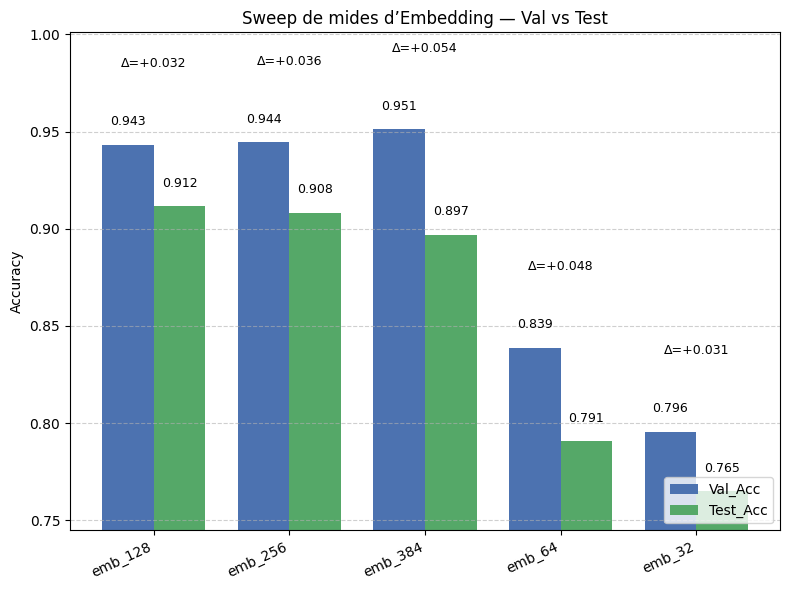

In [ ]:
import numpy as np, matplotlib.pyplot as plt

results = [(f"emb_{d}", va, ta) for (d, va, ta, _) in all_results]

# Extreu dades
cfgs   = [r[0] for r in results]
valacc = np.array([r[1] for r in results], dtype=float)
testacc= np.array([r[2] for r in results], dtype=float)

# Ordena per Test_Acc desc
order  = np.argsort(-testacc)
cfgs_o, val_o, test_o = [np.array(x)[order] for x in (cfgs, valacc, testacc)]

# Bar chart
x = np.arange(len(cfgs_o))
width = 0.38
plt.figure(figsize=(max(8, len(cfgs_o)*0.8), 6))

bars_val  = plt.bar(x - width/2, val_o,  width, label="Val_Acc", color="#4C72B0")
bars_test = plt.bar(x + width/2, test_o, width, label="Test_Acc", color="#55A868")

plt.ylabel("Accuracy")
plt.title("Sweep de mides d’Embedding — Val vs Test")
plt.xticks(x, cfgs_o, rotation=25, ha='right')
ymin = max(0.0, min(val_o.min(), test_o.min()) - 0.02)
ymax = min(1.05, max(val_o.max(), test_o.max()) + 0.05)
plt.ylim(ymin, ymax)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc="lower right")

# Mostra valors i Δ
gap_o = val_o - test_o
for i in range(len(cfgs_o)):
    plt.text(x[i]-width/2, val_o[i]+0.01,  f"{val_o[i]:.3f}",  ha='center', fontsize=9)
    plt.text(x[i]+width/2, test_o[i]+0.01, f"{test_o[i]:.3f}", ha='center', fontsize=9)
    plt.text(x[i], max(val_o[i], test_o[i]) + 0.04, f"Δ={gap_o[i]:+.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# **XARXA CONVOLUCIONAL**

In [ ]:
import numpy as np, tensorflow as tf
from collections import Counter
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D,
    MaxPooling1D, Dense, Dropout, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Checks bàsics
needed = ["X_train","y_train","X_val","y_val","X_test","y_test","vocab_size","num_classes"]
missing = [n for n in needed if n not in globals()]
if missing:
    raise NameError(f"Falten variables globals {missing}. Reutilitza el bloc anterior per preparar dades.")

# Utils
def compute_class_weights(y):
    from collections import Counter
    y = np.asarray(y).astype(int)
    counts = Counter(y.tolist())
    total = sum(counts.values())
    K = int(y.max() + 1)
    return {cls: total/(K * cnt) for cls, cnt in counts.items()}

def ascii_results_table(rows):
    print("\n==================== RESULTATS CNN ====================")
    print(f"{'Config':<22} | {'Best_Val_Acc':>12} | {'Test_Acc':>10} | {'#Params':>10}")
    print("-" * 64)
    for name, va, ta, npm in sorted(rows, key=lambda x: x[1], reverse=True):
        print(f"{name:<22} | {va:>12.4f} | {ta:>10.4f} | {npm:>10}")
    print("-" * 64)

# Paràmetres comuns
EMBED_DIM   = 384
DROPOUT     = 0.3
HIDDEN_FC   = 64
USE_CW      = True
BATCH_SIZE  = 32
EPOCHS      = 10
PATIENCE    = 3

class_weights = compute_class_weights(y_train) if USE_CW else None
early_stop   = EarlyStopping(monitor="val_accuracy", patience=PATIENCE, mode="max", restore_best_weights=True)

# Dissenys CNN
def build_cnn_single_max(vocab_size, embed_dim, num_classes, filters=128, k=5):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim)(inp)
    x = Conv1D(filters, k, activation="relu")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(HIDDEN_FC, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def build_cnn_single_avg(vocab_size, embed_dim, num_classes, filters=128, k=5):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim)(inp)
    x = Conv1D(filters, k, activation="relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(HIDDEN_FC, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def build_cnn_stack_maxpool(vocab_size, embed_dim, num_classes,
                            f1=128, k1=5, f2=128, k2=3, pool_size=2):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim)(inp)
    x = Conv1D(f1, k1, activation="relu")(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    x = Conv1D(f2, k2, activation="relu")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(HIDDEN_FC, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def build_cnn_multikernel(vocab_size, embed_dim, num_classes, filters=64, kernels=(3,4,5)):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim)(inp)
    branches = []
    for k in kernels:
        b = Conv1D(filters, k, activation="relu")(x)
        b = GlobalMaxPooling1D()(b)
        branches.append(b)
    x = Concatenate()(branches) if len(branches) > 1 else branches[0]
    x = Dense(HIDDEN_FC, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

# Catàleg d’experiments
EXPERIMENTS = [
    ("cnn_max_k5_f128",      lambda: build_cnn_single_max(vocab_size, EMBED_DIM, num_classes, filters=128, k=5)),
    ("cnn_avg_k5_f128",      lambda: build_cnn_single_avg(vocab_size, EMBED_DIM, num_classes, filters=128, k=5)),
    ("stack_k5_k3_pool2",    lambda: build_cnn_stack_maxpool(vocab_size, EMBED_DIM, num_classes, 128,5,128,3, pool_size=2)),
    ("stack_k7_k3_pool2",    lambda: build_cnn_stack_maxpool(vocab_size, EMBED_DIM, num_classes, 128,7,128,3, pool_size=2)),
    ("multi_k3_4_5_f64",     lambda: build_cnn_multikernel(vocab_size, EMBED_DIM, num_classes, filters=64, kernels=(3,4,5))),
    ("multi_k2_3_4_f64",     lambda: build_cnn_multikernel(vocab_size, EMBED_DIM, num_classes, filters=64, kernels=(2,3,4))),
]

# Entrenament i avaluació
results = []
models  = {}

for name, build_fn in EXPERIMENTS:
    print(f"\n===== {name} =====")
    model = build_fn()
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weights
    )
    best_val = float(np.max(hist.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
    results.append((name, best_val, test_acc, model.count_params()))
    models[name] = model
    print(f"[{name}] Best Val_Acc={best_val:.4f} | Test_Acc={test_acc:.4f} | Params={model.count_params()}")

# Taula simple i guardat del millor
ascii_results_table(results)

best_name, best_val, best_test, _ = max(results, key=lambda x: x[1])
best_model = models[best_name]
save_path = f"best_cnn__{best_name}.keras"
best_model.save(save_path)
print(f"\n>>> Millor config CNN = {best_name}")
print(f"    • Val_Acc = {best_val:.4f}")
print(f"    • Test_Acc = {best_test:.4f}")
print(f"    • Model desat a: {save_path}")



===== cnn_max_k5_f128 =====
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2190 - loss: 2.7078 - val_accuracy: 0.2767 - val_loss: 2.5278
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3320 - loss: 2.3594 - val_accuracy: 0.6211 - val_loss: 2.0695
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5103 - loss: 1.7597 - val_accuracy: 0.6811 - val_loss: 1.6846
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5199 - loss: 1.0996 - val_accuracy: 0.8111 - val_loss: 1.1995
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6713 - loss: 0.8031 - val_accuracy: 0.8289 - val_loss: 0.8531
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7496 - loss: 0.5453 - val_accuracy: 0.8700 - val_loss: 0.7204
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8267 - loss: 0.2530 - val_accuracy: 0.9133 - val_loss: 0.4412
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8308 - l

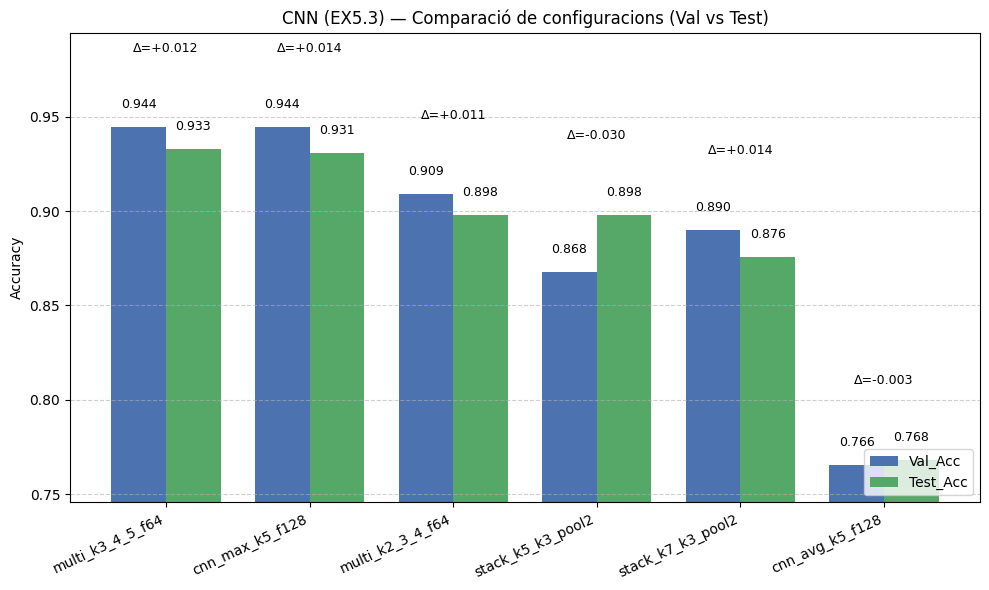

In [ ]:
import numpy as np, matplotlib.pyplot as plt

# Extreu dades
names   = [r[0] for r in results]
valacc  = np.array([r[1] for r in results], dtype=float)
testacc = np.array([r[2] for r in results], dtype=float)

# Ordena per Test_Acc desc
order = np.argsort(-testacc)
names_o, val_o, test_o = [np.array(x)[order] for x in (names, valacc, testacc)]

# Bar chart
x = np.arange(len(names_o))
width = 0.38
plt.figure(figsize=(max(10, len(names_o)*0.9), 6))

bars_val  = plt.bar(x - width/2, val_o,  width, label="Val_Acc", color="#4C72B0")
bars_test = plt.bar(x + width/2, test_o, width, label="Test_Acc", color="#55A868")

plt.ylabel("Accuracy")
plt.title("CNN (EX5.3) — Comparació de configuracions (Val vs Test)")
plt.xticks(x, names_o, rotation=25, ha='right')
ymin = max(0.0, min(val_o.min(), test_o.min()) - 0.02)
ymax = min(1.05, max(val_o.max(), test_o.max()) + 0.05)
plt.ylim(ymin, ymax)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

# Anota valors damunt de cada barra
for i in range(len(names_o)):
    plt.text(x[i]-width/2, val_o[i]+0.01,  f"{val_o[i]:.3f}",  ha='center', fontsize=9)
    plt.text(x[i]+width/2, test_o[i]+0.01, f"{test_o[i]:.3f}", ha='center', fontsize=9)

# Mostra Δ al centre de cada grup
gap = val_o - test_o
for i in range(len(names_o)):
    top = max(val_o[i], test_o[i])
    plt.text(x[i], top + 0.04, f"Δ={gap[i]:+.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# **XARXES RECURRENTS**

In [ ]:
import os, numpy as np, tensorflow as tf
from collections import Counter
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Utils
def compute_class_weights(y):
    y = np.asarray(y).astype(int)
    counts = Counter(y.tolist()); total = sum(counts.values()); K = int(y.max()+1)
    return {c: total/(K*cnt) for c, cnt in counts.items()}

def ascii_results_table(rows, title="RESULTATS RNN"):
    print(f"\n==================== {title} ====================")
    print(f"{'Config':<24} | {'Best_Val_Acc':>12} | {'Test_Acc':>10} | {'#Params':>10}")
    print("-" * 68)
    for name, va, ta, npm in sorted(rows, key=lambda x: x[1], reverse=True):
        print(f"{name:<24} | {va:>12.4f} | {ta:>10.4f} | {npm:>10}")
    print("-" * 68)

def effective_vocab_from_X(X):
    return int(X.max()) + 1 if X.size else 1

needed = ["X_train","y_train","X_val","y_val","X_test","y_test","vocab_size","num_classes"]
missing = [n for n in needed if n not in globals()]
if missing:
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    if not (os.path.exists("./data/train.csv") and os.path.exists("./data/test.csv")):
        raise NameError("No hi ha dades a memòria i no trobo ./data/train.csv i ./data/test.csv")

    train_data = pd.read_csv("./data/train.csv", header=None)
    val_data   = train_data.tail(900)
    train_data = pd.read_csv("./data/train.csv", header=None, nrows=4078)
    test_data  = pd.read_csv("./data/test.csv", header=None)

    def clean_label(x): return str(x).replace('"','').strip().replace(" ","")
    tr_sent = list(train_data[0]); va_sent = list(val_data[0]); te_sent = list(test_data[0])
    tr_lab  = [clean_label(x) for x in list(train_data[2])]
    va_lab  = [clean_label(x) for x in list(val_data[2])]
    te_lab  = [clean_label(x) for x in list(test_data[2])]

    tok = Tokenizer(num_words=5000, oov_token="<OOV>", lower=True)
    tok.fit_on_texts(tr_sent)
    tr_seqs = tok.texts_to_sequences(tr_sent)
    va_seqs = tok.texts_to_sequences(va_sent)
    te_seqs = tok.texts_to_sequences(te_sent)

    maxlen = max(1, int(np.percentile([len(s) for s in tr_seqs], 95)))
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    X_train = pad_sequences(tr_seqs, maxlen=maxlen, padding='post', truncating='post')
    X_val   = pad_sequences(va_seqs, maxlen=maxlen, padding='post', truncating='post')
    X_test  = pad_sequences(te_seqs, maxlen=maxlen, padding='post', truncating='post')

    le = LabelEncoder()
    y_train = le.fit_transform(tr_lab)
    y_val   = le.transform(va_lab)
    y_test  = le.transform(te_lab)

    vocab_size  = effective_vocab_from_X(X_train)
    num_classes = len(le.classes_)
    print(f"✓ Dades carregades | maxlen={maxlen} | vocab_size={vocab_size} | classes={num_classes}")

# Paràmetres
EMBED_DIM  = 384
UNITS      = 64
DROPOUT    = 0.3
FC_UNITS   = 64
BATCH_SIZE = 32
EPOCHS     = 10
PATIENCE   = 3
USE_CW     = True

class_weights = compute_class_weights(y_train) if USE_CW else None
early_stop   = EarlyStopping(monitor="val_accuracy", patience=PATIENCE, mode="max", restore_best_weights=True)

# Constructors de models
def rnn_lstm_last(vocab_size, embed_dim, num_classes, units=64):
    """Embedding amb mask → LSTM retorna l'últim estat (respecta padding)."""
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = LSTM(units)(x)                          # last hidden state
    x = Dense(FC_UNITS, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def rnn_gru_last(vocab_size, embed_dim, num_classes, units=64):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = GRU(units)(x)
    x = Dense(FC_UNITS, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def rnn_bilstm_last(vocab_size, embed_dim, num_classes, units=64):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = Bidirectional(LSTM(units))(x)
    x = Dense(FC_UNITS, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def rnn_lstm_seq_max(vocab_size, embed_dim, num_classes, units=64):
    """Sense màscara + return_sequences + GlobalMaxPooling (robust a pics locals)."""
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim, mask_zero=False)(inp)
    x = LSTM(units, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(FC_UNITS, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def rnn_bilstm_stacked(vocab_size, embed_dim, num_classes, units=64):
    """BiLSTM → BiLSTM (stacked): més capacitat per seqüències llargues."""
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = Bidirectional(LSTM(units))(x)
    x = Dense(FC_UNITS, activation="relu")(x)
    x = Dropout(DROPOUT)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

# Catàleg d’experiments
EXPERIMENTS = [
    ("lstm_last_u64",      lambda: rnn_lstm_last(vocab_size, EMBED_DIM, num_classes, units=UNITS)),
    ("gru_last_u64",       lambda: rnn_gru_last(vocab_size, EMBED_DIM, num_classes, units=UNITS)),
    ("bilstm_last_u64",    lambda: rnn_bilstm_last(vocab_size, EMBED_DIM, num_classes, units=UNITS)),
    ("lstm_seq_max_u64",   lambda: rnn_lstm_seq_max(vocab_size, EMBED_DIM, num_classes, units=UNITS)),
    ("bilstm_stacked_u64", lambda: rnn_bilstm_stacked(vocab_size, EMBED_DIM, num_classes, units=UNITS)),
]

# Entrenament i avaluació
results = []; models = {}
for name, build_fn in EXPERIMENTS:
    print(f"\n===== {name} =====")
    model = build_fn()
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weights
    )
    best_val = float(np.max(hist.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
    results.append((name, best_val, test_acc, model.count_params()))
    models[name] = model
    print(f"[{name}] Best Val_Acc={best_val:.4f} | Test_Acc={test_acc:.4f} | Params={model.count_params()}")

# Taula simple i guardat del millor
ascii_results_table(results, title="RESULTATS RNN (LSTM/GRU)")
best_name, best_val, best_test, _ = max(results, key=lambda x: x[1])
best_model = models[best_name]
save_path = f"best_rnn__{best_name}.keras"
best_model.save(save_path)
print(f"\n>>> Millor config RNN = {best_name}")
print(f"    • Val_Acc = {best_val:.4f}")
print(f"    • Test_Acc = {best_test:.4f}")
print(f"    • Model desat a: {save_path}")



===== lstm_last_u64 =====
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5098 - loss: 2.7297 - val_accuracy: 0.1178 - val_loss: 2.9586
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2615 - loss: 2.5515 - val_accuracy: 0.3511 - val_loss: 2.1960
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3888 - loss: 2.0419 - val_accuracy: 0.4022 - val_loss: 1.6528
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3892 - loss: 1.5691 - val_accuracy: 0.6244 - val_loss: 1.3846
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5033 - loss: 1.2246 - val_accuracy: 0.4800 - val_loss: 1.3210
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5019 - loss: 0.9626 - val_accuracy: 0.5100 - val_loss: 1.1953
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5518 - loss: 0.6544 - val_accuracy: 0.6656 - val_loss: 0.9079
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6898 - 

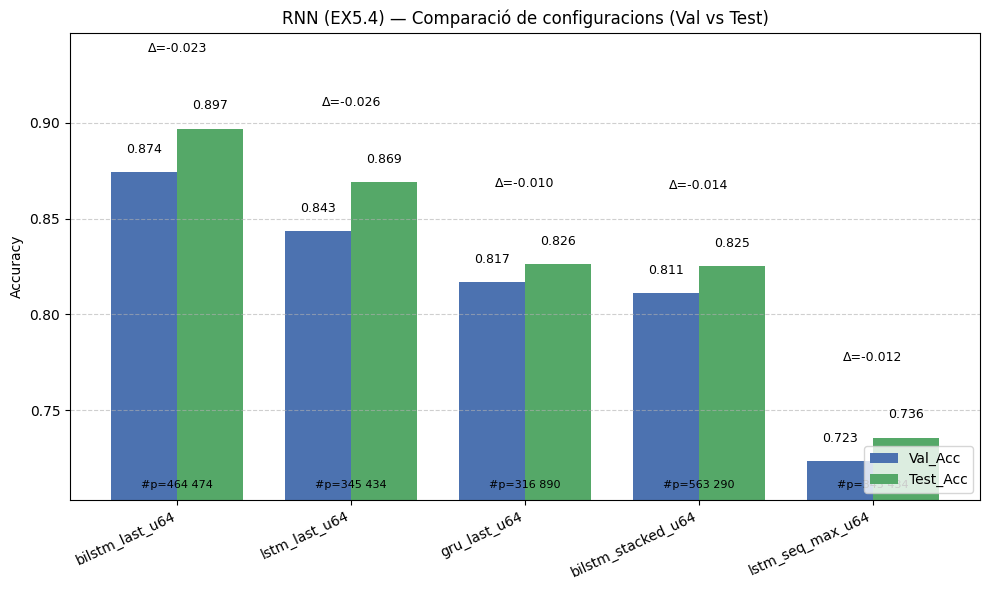

In [ ]:
import numpy as np, matplotlib.pyplot as plt

# Extreu dades
names   = [r[0] for r in results]
valacc  = np.array([r[1] for r in results], dtype=float)
testacc = np.array([r[2] for r in results], dtype=float)
has_params = all(len(r) >= 4 for r in results)
if has_params:
    params = np.array([r[3] for r in results], dtype=int)

# Ordena per Test_Acc desc
order = np.argsort(-testacc)
names_o, val_o, test_o = [np.array(x)[order] for x in (names, valacc, testacc)]
if has_params:
    params_o = np.array(params)[order]

# Bar chart
x = np.arange(len(names_o))
width = 0.38
plt.figure(figsize=(max(10, len(names_o)*0.9), 6))

bars_val  = plt.bar(x - width/2, val_o,  width, label="Val_Acc",  color="#4C72B0")
bars_test = plt.bar(x + width/2, test_o, width, label="Test_Acc", color="#55A868")

plt.ylabel("Accuracy")
plt.title("RNN (EX5.4) — Comparació de configuracions (Val vs Test)")
plt.xticks(x, names_o, rotation=25, ha='right')
ymin = max(0.0, min(val_o.min(), test_o.min()) - 0.02)
ymax = min(1.05, max(val_o.max(), test_o.max()) + 0.05)
plt.ylim(ymin, ymax)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

# Anota valors
for i in range(len(names_o)):
    plt.text(x[i]-width/2, val_o[i]+0.01,  f"{val_o[i]:.3f}",  ha='center', fontsize=9)
    plt.text(x[i]+width/2, test_o[i]+0.01, f"{test_o[i]:.3f}", ha='center', fontsize=9)

# Δ = Val - Test
gap = val_o - test_o
for i in range(len(names_o)):
    top = max(val_o[i], test_o[i])
    plt.text(x[i], top + 0.04, f"Δ={gap[i]:+.3f}", ha='center', fontsize=9)

# Params
if has_params:
    for i in range(len(names_o)):
        plt.text(x[i], ymin + (ymax - ymin)*0.02, f"#p={int(params_o[i]):,}".replace(",", " "),
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# **REGULARITZACIÓ**

## **Opció A) CNN + SpatialDropout1D**

In [ ]:
import numpy as np, tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Requereix: X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, num_classes
for n in ["X_train","y_train","X_val","y_val","X_test","y_test","vocab_size","num_classes"]:
    assert n in globals(), f"Falta {n}"

def ascii_table(rows, title):
    print(f"\n==================== {title} ====================")
    print(f"{'spDrop':<7} | {'denseDrop':<9} | {'Val_Acc':>8} | {'Test_Acc':>8} | {'#Params':>8}")
    print("-"*64)
    for sdrop, ddrop, va, ta, npm in sorted(rows, key=lambda x: x[2], reverse=True):
        print(f"{sdrop:<7.2f} | {ddrop:<9.2f} | {va:>8.4f} | {ta:>8.4f} | {npm:>8}")
    print("-"*64)

EMBED_DIM=128; FILTERS=128; K=5; FC=64; BATCH=32; EPOCHS=10
early = EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=True)

def build_cnn(vocab_size, embed_dim, num_classes, sp_drop=0.0, dense_drop=0.0):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim)(inp)
    if sp_drop > 0:
        x = SpatialDropout1D(sp_drop)(x)  # apaga vectors de paraula sencers
    x = Conv1D(FILTERS, K, activation="relu")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(FC, activation="relu")(x)
    if dense_drop > 0:
        x = Dropout(dense_drop)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

SP_DROPS   = [0.0, 0.2, 0.3]
DENSEDROPS = [0.0, 0.3, 0.5]

results=[]; models={}
for sd in SP_DROPS:
    for dd in DENSEDROPS:
        name=f"cnn_sd{sd}_dd{dd}"
        print(f"\n===== {name} =====")
        m = build_cnn(vocab_size, EMBED_DIM, num_classes, sp_drop=sd, dense_drop=dd)
        h = m.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=EPOCHS, batch_size=BATCH, callbacks=[early], verbose=1)
        best_val = float(np.max(h.history['val_accuracy']))
        test_loss, test_acc = m.evaluate(X_test, y_test, batch_size=BATCH, verbose=0)
        results.append((sd, dd, best_val, test_acc, m.count_params()))
        models[(sd, dd)] = m
        print(f"[{name}] Val={best_val:.4f} | Test={test_acc:.4f} | Params={m.count_params()}")

ascii_table(results, "DROP-OUT (CNN) — sense L2")

# Selecciona pel millor val_accuracy
best = max(results, key=lambda x: x[2])
(sd, dd, va, ta, _) = best
best_model = models[(sd, dd)]
save_path = f"best_reg_cnn__dropout.keras"
best_model.save(save_path)
print(f"\n>>> Millor (CNN): spDrop={sd}, denseDrop={dd} | Val={va:.4f} | Test={ta:.4f}")
print(f"Model desat a: {save_path}")


===== cnn_sd0.0_dd0.0 =====
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7336 - loss: 1.5625 - val_accuracy: 0.8856 - val_loss: 0.5071
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8986 - loss: 0.3947 - val_accuracy: 0.9367 - val_loss: 0.2666
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9576 - loss: 0.1708 - val_accuracy: 0.9567 - val_loss: 0.2098
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.1000 - val_accuracy: 0.9611 - val_loss: 0.1833
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9886 - loss: 0.0593 - val_accuracy: 0.9711 - val_loss: 0.1717
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9958 - loss: 0.0343 - val_accuracy: 0.9667 - val_loss: 0.1532
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9969 - loss: 0.0203 - val_accuracy: 0.9700 - val_loss: 0.1500
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - l

## **Opció B) RNN (LSTM) + Dropout & Recurrent Dropout**

In [ ]:
import numpy as np, tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Requereix: X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, num_classes
for n in ["X_train","y_train","X_val","y_val","X_test","y_test","vocab_size","num_classes"]:
    assert n in globals(), f"Falta {n}"

def ascii_table(rows, title):
    print(f"\n==================== {title} ====================")
    print(f"{'recDrop':<7} | {'denseDrop':<9} | {'Val_Acc':>8} | {'Test_Acc':>8} | {'#Params':>8}")
    print("-"*64)
    for rd, dd, va, ta, npm in sorted(rows, key=lambda x: x[2], reverse=True):
        print(f"{rd:<7.2f} | {dd:<9.2f} | {va:>8.4f} | {ta:>8.4f} | {npm:>8}")
    print("-"*64)

EMBED_DIM=128; UNITS=64; FC=64; BATCH=32; EPOCHS=10
early = EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=True)

def build_lstm(vocab_size, embed_dim, num_classes, rec_drop=0.0, dense_drop=0.0):
    inp = Input(shape=(X_train.shape[1],))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = LSTM(UNITS, recurrent_dropout=rec_drop)(x)
    x = Dense(FC, activation="relu")(x)
    if dense_drop > 0:
        x = Dropout(dense_drop)(x)
    out = Dense(num_classes, activation="softmax")(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

REC_DROPS  = [0.0, 0.2, 0.3]
DENSEDROPS = [0.0, 0.3, 0.5]

results=[]; models={}
for rd in REC_DROPS:
    for dd in DENSEDROPS:
        name=f"lstm_rd{rd}_dd{dd}"
        print(f"\n===== {name} =====")
        m = build_lstm(vocab_size, EMBED_DIM, num_classes, rec_drop=rd, dense_drop=dd)
        h = m.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=EPOCHS, batch_size=BATCH, callbacks=[early], verbose=1)
        best_val = float(np.max(h.history['val_accuracy']))
        test_loss, test_acc = m.evaluate(X_test, y_test, batch_size=BATCH, verbose=0)
        results.append((rd, dd, best_val, test_acc, m.count_params()))
        models[(rd, dd)] = m
        print(f"[{name}] Val={best_val:.4f} | Test={test_acc:.4f} | Params={m.count_params()}")

ascii_table(results, "DROP-OUT (LSTM) — sense L2")

# Selecció pel millor val_accuracy
best = max(results, key=lambda x: x[2])
(rd, dd, va, ta, _) = best
best_model = models[(rd, dd)]
save_path = "best_reg_lstm__dropout.keras"
best_model.save(save_path)
print(f"\n>>> Millor (LSTM): recDrop={rd}, denseDrop={dd} | Val={va:.4f} | Test={ta:.4f}")
print(f"Model desat a: {save_path}")


===== lstm_rd0.0_dd0.0 =====
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7111 - loss: 1.8717 - val_accuracy: 0.7678 - val_loss: 0.8147
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8265 - loss: 0.6655 - val_accuracy: 0.8922 - val_loss: 0.4716
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8873 - loss: 0.3978 - val_accuracy: 0.9111 - val_loss: 0.3721
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9284 - loss: 0.2771 - val_accuracy: 0.9244 - val_loss: 0.3379
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9448 - loss: 0.2023 - val_accuracy: 0.9344 - val_loss: 0.2978
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9667 - loss: 0.1402 - val_accuracy: 0.9311 - val_loss: 0.3214
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9749 - loss: 0.1085 - val_accuracy: 0.9433 - val_loss: 0.2587
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9762 - l

In [ ]:
# COMPARAR I ESCOLLIR MILLOR MODEL (CNN vs LSTM)
import os, shutil, numpy as np
from tensorflow.keras.models import load_model

# Helpers
def ensure_1d_int(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        arr = arr.argmax(axis=1)
    return arr.astype("int32")

# Comprovacions bàsiques
for n in ["X_val","y_val","X_test","y_test"]:
    assert n in globals(), f"Falta {n}. Carrega/crea les dades abans."

y_val_idx  = ensure_1d_int(y_val)
y_test_idx = ensure_1d_int(y_test)

CANDIDATES = [
    "best_reg_cnn__dropout.keras",
    "best_reg_lstm__dropout.keras",
]

# Filtra només els models que existeixen
MODEL_PATHS = [p for p in CANDIDATES if os.path.exists(p)]
assert MODEL_PATHS, "No s'ha trobat cap dels models esperats .keras"

results = []
for mp in MODEL_PATHS:
    m = load_model(mp)
    # Avalua en val i test
    val_loss,  val_acc  = m.evaluate(X_val,  y_val_idx,  verbose=0)
    test_loss, test_acc = m.evaluate(X_test, y_test_idx, verbose=0)
    params = m.count_params()
    results.append((mp, float(val_acc), float(test_acc), int(params)))
    print(f"{mp}: val={val_acc:.4f} | test={test_acc:.4f} | params={params}")

# Taula simple
print("\n==================== COMPARATIU (CNN vs LSTM) ====================")
print(f"{'Model':<32} | {'Val_Acc':>8} | {'Test_Acc':>9} | {'#Params':>9}")
print("-"*70)
for p, va, ta, n in sorted(results, key=lambda x: (x[2], -x[3]), reverse=True):
    print(f"{os.path.basename(p):<32} | {va:>8.4f} | {ta:>9.4f} | {n:>9}")
print("-"*70)

# Selecció: millor Test_Acc; si empaten, menys paràmetres
best_path, best_val, best_test, best_params = sorted(
    results, key=lambda x: (x[2], -x[3]), reverse=True
)[0]

# Copia el fitxer guanyador com a model final
FINAL_PATH = "best_model_final.keras"
shutil.copyfile(best_path, FINAL_PATH)

print(f"\n>>> MILLOR MODEL: {os.path.basename(best_path)}")
print(f"    • Val_Acc  = {best_val:.4f}")
print(f"    • Test_Acc = {best_test:.4f}")
print(f"    • #Params  = {best_params}")
print(f"    • Guardat com: {FINAL_PATH}")

best_reg_cnn__dropout.keras: val=0.9722 | test=0.9418 | params=166874
best_reg_lstm__dropout.keras: val=0.9667 | test=0.9205 | params=130138

==================== COMPARATIU (CNN vs LSTM) ====================
Model                            |  Val_Acc |  Test_Acc |   #Params
----------------------------------------------------------------------
best_reg_cnn__dropout.keras      |   0.9722 |    0.9418 |    166874
best_reg_lstm__dropout.keras     |   0.9667 |    0.9205 |    130138
----------------------------------------------------------------------

>>> MILLOR MODEL: best_reg_cnn__dropout.keras
    • Val_Acc  = 0.9722
    • Test_Acc = 0.9418
    • #Params  = 166874
    • Guardat com: best_model_final.keras


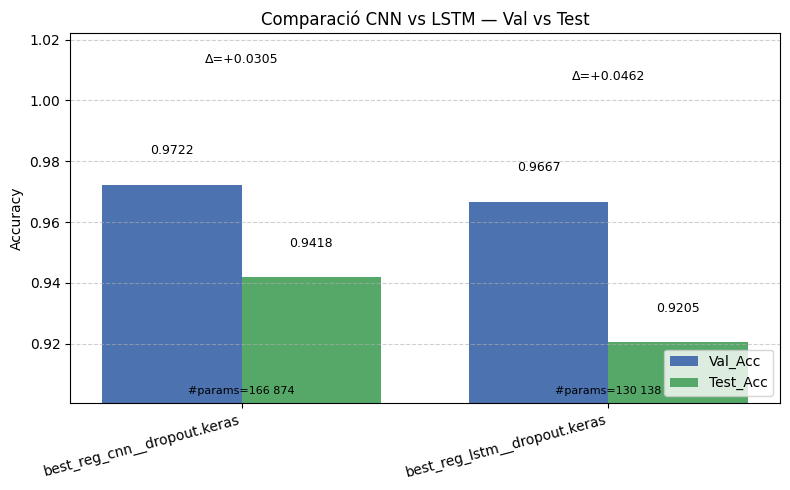

In [ ]:
import os, numpy as np, matplotlib.pyplot as plt

# Extracció flexible
names   = [os.path.basename(r[0]) for r in results]
valacc  = np.array([r[1] for r in results], dtype=float)
testacc = np.array([r[2] for r in results], dtype=float)
has_params = all(len(r) >= 4 for r in results)
if has_params:
    params = np.array([r[3] for r in results], dtype=int)

# Ordena per Test_Acc desc
order = np.argsort(-testacc)
names_o, val_o, test_o = [np.array(x)[order] for x in (names, valacc, testacc)]
if has_params:
    params_o = np.array(params)[order]

# Barres verticals
x = np.arange(len(names_o))
width = 0.38
plt.figure(figsize=(8, 5))

bars_val  = plt.bar(x - width/2, val_o,  width, label='Val_Acc',  color='#4C72B0')
bars_test = plt.bar(x + width/2, test_o, width, label='Test_Acc', color='#55A868')

plt.ylabel('Accuracy')
plt.title('Comparació CNN vs LSTM — Val vs Test')
plt.xticks(x, names_o, rotation=15, ha='right')
ymin = max(0.0, min(val_o.min(), test_o.min()) - 0.02)
ymax = min(1.05, max(val_o.max(), test_o.max()) + 0.05)
plt.ylim(ymin, ymax)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

# Anotacions sobre les barres
for i in range(len(names_o)):
    plt.text(x[i]-width/2, val_o[i]+0.01,  f"{val_o[i]:.4f}", ha='center', fontsize=9)
    plt.text(x[i]+width/2, test_o[i]+0.01, f"{test_o[i]:.4f}", ha='center', fontsize=9)

# Diferència Δ = Val - Test
gap = val_o - test_o
for i in range(len(names_o)):
    top = max(val_o[i], test_o[i])
    plt.text(x[i], top + 0.04, f"Δ={gap[i]:+.4f}", ha='center', fontsize=9)

# Params
if has_params:
    for i in range(len(names_o)):
        plt.text(x[i], ymin + (ymax - ymin)*0.02,
                 f"#params={int(params_o[i]):,}".replace(",", " "),
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


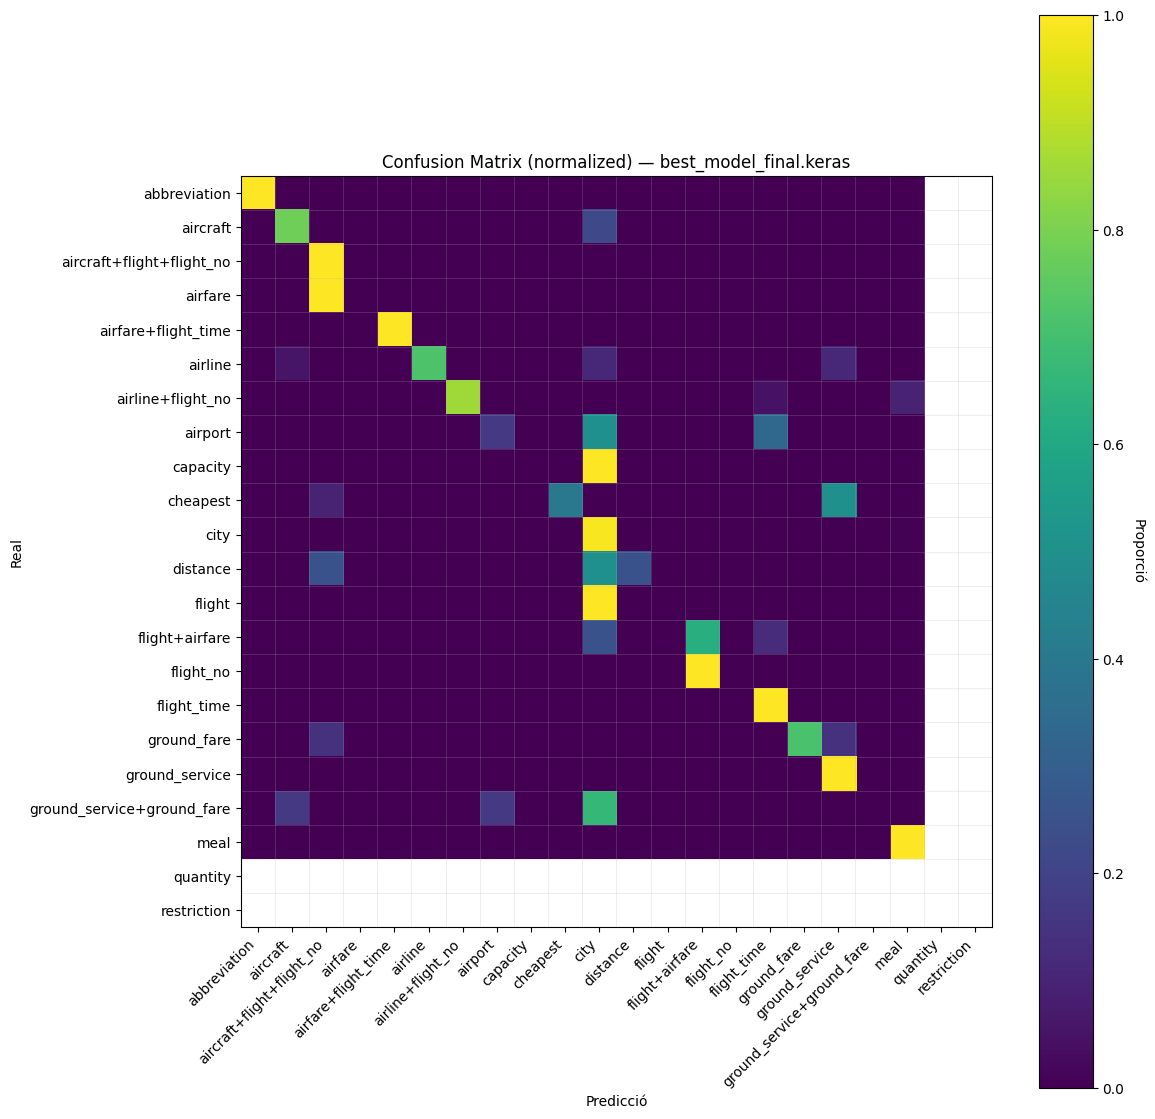

In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Model a carregar
mp = "best_model_final.keras"

y_true = np.asarray(y_test)
if y_true.ndim == 2:
    y_true = y_true.argmax(1)

# Prediccions
y_pred = load_model(mp).predict(X_test, verbose=0).argmax(1)

# Matriu de confusió (normalitzada per files)
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1, keepdims=True)
cm = np.nan_to_num(cm)

# Noms de classe
names = None
if "label_encoder" in globals():
    names = list(label_encoder.classes_)
elif "label_encoder_global" in globals():
    names = list(label_encoder_global.classes_)
if names is None:
    names = [str(i) for i in range(cm.shape[0])]

# PLOT
plt.figure(figsize=(12, 12))
im = plt.imshow(cm, interpolation='nearest', vmin=0.0, vmax=1.0)

plt.title(f"Confusion Matrix (normalized) — {os.path.basename(mp)}")
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Proporció", rotation=270, labelpad=15)

ticks = np.arange(len(names))
plt.xticks(ticks, names, rotation=45, ha='right')
plt.yticks(ticks, names)
plt.xlabel("Predicció")
plt.ylabel("Real")

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, len(names), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(names), 1), minor=True)
ax.grid(which="minor", linestyle='-', linewidth=0.5, alpha=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()


# **BALANCEIG DE CLASSES**

In [ ]:
import os, numpy as np
from collections import Counter, defaultdict
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

# Requisits
for n in ["X_train","y_train","X_val","y_val","X_test","y_test"]:
    assert n in globals(), f"Falta {n}. Carrega/crea les dades abans."

BEST_MODEL_PATH = "best_model_final.keras"
assert os.path.exists(BEST_MODEL_PATH), f"No trobo {BEST_MODEL_PATH}"

# Helpers
def ensure_1d_int(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        arr = arr.argmax(axis=1)
    return arr.astype("int32")

def compute_class_weights_strict(y_idx, clip_max=10.0, normalize_mean1=True):
    y_idx = ensure_1d_int(y_idx)
    counts = Counter(y_idx.tolist())
    K = len(counts)
    N = len(y_idx)

    weights = {}
    for c, cnt in counts.items():
        w = N / (K * cnt)
        if clip_max is not None:
            w = min(w, clip_max)
        weights[c] = w

    if normalize_mean1 and len(weights) > 0:
        mean_w = float(np.mean(list(weights.values())))
        weights = {c: w/mean_w for c, w in weights.items()}

    return weights, counts

def oversample_to_balance(X, y_idx, seed=42):
    """
    Repeteix mostres de classes minoritàries fins igualar la freq. màxima.
    Manté ordre aleatori final.
    """
    rng = np.random.RandomState(seed)
    y_idx = ensure_1d_int(y_idx)
    X = np.asarray(X)

    counts = Counter(y_idx.tolist())
    max_count = max(counts.values())

    # recull índexs per classe
    idxs_per_class = {c: np.where(y_idx == c)[0] for c in counts.keys()}

    picked = []
    for c, idxs in idxs_per_class.items():
        reps, rem = divmod(max_count, len(idxs))
        block = np.concatenate([np.tile(idxs, reps), rng.choice(idxs, size=rem, replace=False)])
        picked.append(block)

    picked = np.concatenate(picked)
    rng.shuffle(picked)

    return X[picked], y_idx[picked]

def run_refit(model_path, Xtr, ytr, Xva, yva, Xte, yte, class_weight=None,
              epochs=10, batch=32, monitor="val_accuracy", mode="max", verbose=1):
    """
    Carrega model base, compila, entrena, avalua i retorna:
      (val_acc_best, test_acc, model, history)
    """
    model = load_model(model_path)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    early = EarlyStopping(monitor=monitor, patience=3, mode=mode, restore_best_weights=True)

    ytr_idx = ensure_1d_int(ytr)
    yva_idx = ensure_1d_int(yva)
    yte_idx = ensure_1d_int(yte)

    hist = model.fit(
        Xtr, ytr_idx,
        validation_data=(Xva, yva_idx),
        epochs=epochs,
        batch_size=batch,
        class_weight=class_weight,
        callbacks=[early],
        verbose=verbose
    )
    # millor val_acc al training
    val_acc_best = float(np.max(hist.history.get("val_accuracy", [0.0])))

    # test
    ypred = model.predict(Xte, verbose=0).argmax(1)
    test_acc = float(accuracy_score(yte_idx, ypred))

    return val_acc_best, test_acc, model, hist
# Etiquetes com a índexs (un cop aquí per reutilitzar)
y_train_idx = ensure_1d_int(y_train)
y_val_idx   = ensure_1d_int(y_val)
y_test_idx  = ensure_1d_int(y_test)

In [ ]:
# 1) BÀSIC (sense balanceig)

print("\n[1/3] Entrenant BÀSIC (sense class_weight ni oversampling)")
val_basic, test_basic, model_basic, _ = run_refit(
    BEST_MODEL_PATH, X_train, y_train, X_val, y_val, X_test, y_test,
    class_weight=None, epochs=10, batch=32, monitor="val_accuracy", mode="max", verbose=1
)
BASIC_PATH = "best_model__basic_refit.keras"
model_basic.save(BASIC_PATH)
print(f"Guardat: {BASIC_PATH}")
print(f"   → Val_Acc={val_basic:.4f} | Test_Acc={test_basic:.4f}")


[1/3] Entrenant BÀSIC (sense class_weight ni oversampling)
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9934 - loss: 0.0426 - val_accuracy: 0.9689 - val_loss: 0.1540
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0247 - val_accuracy: 0.9711 - val_loss: 0.1558
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.0144 - val_accuracy: 0.9700 - val_loss: 0.1521
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0088 - val_accuracy: 0.9733 - val_loss: 0.1554
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0058 - val_accuracy: 0.9711 - val_loss: 0.1646
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9689 - val_loss: 0.1815
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9767 - val_loss: 0.1635
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# 2) CLASS_WEIGHT (pesos estrictes)

print("\n[2/3] Entrenant amb CLASS_WEIGHT")
class_weights, counts = compute_class_weights_strict(y_train_idx, clip_max=10.0, normalize_mean1=True)

# Imprimeix resum pesos
print("\n=== Freqüències i pesos (classes presents) ===")
for c in sorted(counts.keys(), key=lambda k: counts[k]):
    print(f"classe {c:>3} | count={counts[c]:>5} | weight={class_weights[c]:>6.3f}")

val_cw, test_cw, model_cw, _ = run_refit(
    BEST_MODEL_PATH, X_train, y_train, X_val, y_val, X_test, y_test,
    class_weight=class_weights, epochs=10, batch=32, monitor="val_loss", mode="min", verbose=1
)
CW_PATH = "best_model__classweight.keras"
model_cw.save(CW_PATH)
print(f"Guardat: {CW_PATH}")
print(f"   → Val_Acc={val_cw:.4f} | Test_Acc={test_cw:.4f}")


[2/3] Entrenant amb CLASS_WEIGHT

=== Freqüències i pesos (classes presents) ===
classe  22 | count=    1 | weight= 1.419
classe   5 | count=    1 | weight= 1.419
classe  10 | count=    1 | weight= 1.419
classe   2 | count=    1 | weight= 1.419
classe  25 | count=    2 | weight= 1.419
classe   7 | count=    2 | weight= 1.419
classe  23 | count=    3 | weight= 1.419
classe  17 | count=   11 | weight= 1.419
classe   9 | count=   13 | weight= 1.419
classe   8 | count=   14 | weight= 1.419
classe  13 | count=   15 | weight= 1.419
classe  20 | count=   15 | weight= 1.419
classe  15 | count=   15 | weight= 1.419
classe  11 | count=   16 | weight= 1.419
classe  19 | count=   46 | weight= 0.572
classe  24 | count=   50 | weight= 0.526
classe   1 | count=   68 | weight= 0.387
classe   0 | count=  120 | weight= 0.219
classe   6 | count=  125 | weight= 0.210
classe  21 | count=  203 | weight= 0.130
classe   3 | count=  333 | weight= 0.079
classe  14 | count= 3023 | weight= 0.009
Epoch 1/10
128/1

In [ ]:
# 3) OVERSAMPLING (naive)

print("\n[3/3] Entrenant amb OVERSAMPLING")
X_train_bal, y_train_bal = oversample_to_balance(X_train, y_train_idx, seed=42)

val_os, test_os, model_os, _ = run_refit(
    BEST_MODEL_PATH, X_train_bal, y_train_bal, X_val, y_val, X_test, y_test,
    class_weight=None, epochs=10, batch=32, monitor="val_accuracy", mode="max", verbose=1
)
OS_PATH = "best_model__oversampling.keras"
model_os.save(OS_PATH)
print(f"Guardat: {OS_PATH}")
print(f"   → Val_Acc={val_os:.4f} | Test_Acc={test_os:.4f}")


[3/3] Entrenant amb OVERSAMPLING
Epoch 1/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9893 - loss: 0.0674 - val_accuracy: 0.9733 - val_loss: 0.1865
Epoch 2/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9689 - val_loss: 0.2324
Epoch 3/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9733 - val_loss: 0.2383
Epoch 4/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9998 - loss: 8.4760e-04 - val_accuracy: 0.9678 - val_loss: 0.2852
Guardat: best_model__oversampling.keras
   → Val_Acc=0.9733 | Test_Acc=0.9619


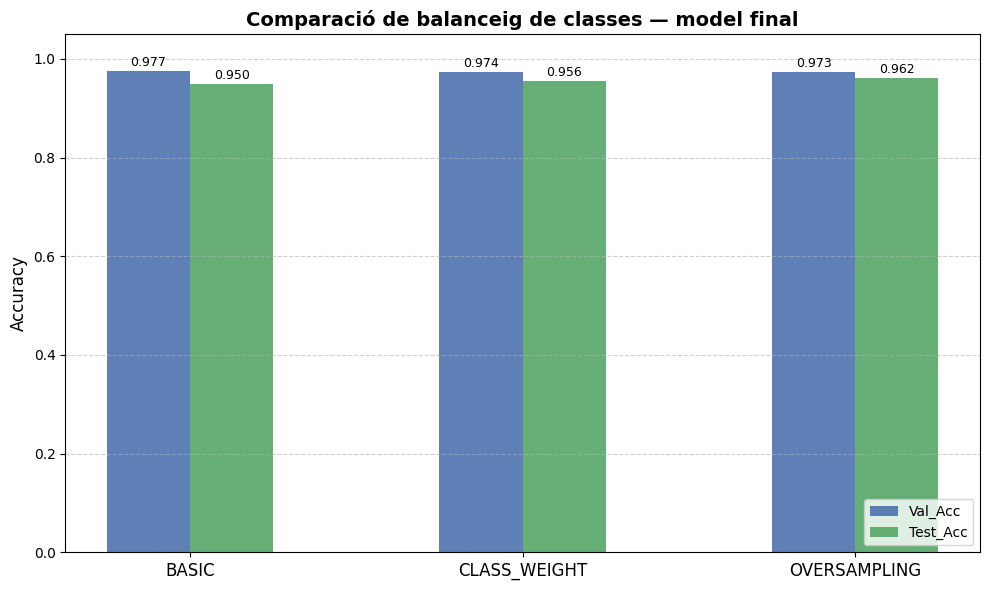

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Resultats obtinguts
labels = ['BASIC', 'CLASS_WEIGHT', 'OVERSAMPLING']

cnn_val  = [val_basic, val_cw, val_os]
cnn_test = [test_basic, test_cw, test_os]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10,6))

# CNN
plt.bar(x - width/2, cnn_val,  width, label='Val_Acc',  color='#4C72B0', alpha=0.9)
plt.bar(x + width/2, cnn_test, width, label='Test_Acc', color='#55A868', alpha=0.9)

# Format i estètica
plt.xticks(x, labels, fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparació de balanceig de classes — model final', fontsize=14, fontweight='bold')
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i in range(len(labels)):
    plt.text(x[i]-width/2, cnn_val[i]+0.01,  f"{cnn_val[i]:.3f}", ha='center', fontsize=9)
    plt.text(x[i]+width/2, cnn_test[i]+0.01, f"{cnn_test[i]:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()



<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---